In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LdaModel, KeyedVectors
import pyLDAvis.gensim_models
import pyLDAvis
import spacy
from nltk.corpus import stopwords
import nltk
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')
nltk.download('punkt')

nlp = spacy.load("en_core_web_sm")

nltk_stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\karti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def remove_special_chars_and_punctuation(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)

def remove_single_alphabet_tokens(text):
    return re.sub(r'\b[a-zA-Z]\b', '', text)

def remove_numerical_tokens(text):
    return re.sub(r'\b\d+\b', '', text)

def remove_alphanumeric_tokens(text):
    return re.sub(r'\b(?=.*\d)(?=.*[a-zA-Z])[a-zA-Z0-9]+\b', '', text)

def remove_pgp_key_patterns(text):
    return re.sub(r'\b(pgp|begin|end|key|public|block)\b', '', text, flags=re.IGNORECASE)

def remove_tokens_with_non_standard_characters(text):
    return re.sub(r'[^\x00-\x7F]+', '', text)

def custom_preprocessor(text):
    text = remove_special_chars_and_punctuation(text)
    text = remove_single_alphabet_tokens(text)
    text = remove_numerical_tokens(text)
    text = remove_alphanumeric_tokens(text)
    text = remove_pgp_key_patterns(text)
    text = remove_tokens_with_non_standard_characters(text)
    words = text.lower().split()
    words = [word for word in words if word not in nltk_stopwords]
    return ' '.join(words)

def extract_nouns_pronouns_and_ner(text, ner_labels=None):
    doc = nlp(text)
    
    if ner_labels is None:
        ner_labels = ['PERSON', 'NORP', 'FAC', 'ORG', 'GPE', 'LOC', 'PRODUCT', 'EVENT'] 
    
    extracted_terms = set()
    
    for token in doc:
        if token.pos_ in ['NOUN', 'PROPN'] and token.text.lower() not in nltk_stopwords:
            extracted_terms.add(token.text)
        elif token.ent_type_ in ner_labels:
            extracted_terms.add(token.text)

    processed_terms = [custom_preprocessor(term) for term in extracted_terms]
    
    return ' '.join([term for term in processed_terms if term.strip()])

In [3]:
def calculate_topic_diversity(lda_model, num_top_words=30):
    topics = lda_model.show_topics(num_topics=-1, num_words=num_top_words, formatted=False)
    all_top_words = [word for topic in topics for word, _ in topic[1]]
    unique_words = set(all_top_words)
    total_words = len(all_top_words)
    topic_diversity_score = len(unique_words) / total_words if total_words > 0 else 0
    return topic_diversity_score

def save_top_words_combined(lda_model, year, num_words=30, filename='noun_ner_top_words_all_years.txt'):
    with open(filename, 'a') as f:
        f.write(f"Year: {year}\n")
        f.write("=" * 40 + "\n")
        for idx, topic in lda_model.print_topics(num_topics=-1, num_words=num_words):
            f.write(f"Topic {idx + 1}:\n")
            f.write(topic + '\n\n')
        f.write("\n\n")
    print(f"Top {num_words} words for each topic saved for year {year} into {filename}.")

In [4]:
input_file_path = 'cleaned_english_posts.csv'
data = pd.read_csv(input_file_path)

# Applying processing
data['processed_content'] = data['post_content'].fillna('').apply(lambda x: extract_nouns_pronouns_and_ner(str(x)))

# Removing empty rows
data = data[data['processed_content'].str.strip() != '']

# Getting the unique years
years = data['year'].unique()

In [5]:
fasttext_model_path = 'final_fasttext_model.bin'

fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path, binary=True)

print(f"FastText model loaded from {fasttext_model_path}")

FastText model loaded from final_fasttext_model.bin


In [6]:
# Initializing lists to store results
topic_diversity_scores = []
iwec_scores_per_year = {}
years_list = []
doc_counts = []

# Initializing variables for weighted averaging
total_docs = 0
weighted_diversity = 0
overall_weighted_iwec = 0

In [8]:
# Looping through each year's data and compute diversity and save visualizations
num_topics = 10  # Adjust the number of topics as needed
n_top_words = 10  # Number of top words per topic
random_state = 42

for year in years:
    # Filtering the DataFrame for the specific year
    df_year = data[data['year'] == year]
    
    # Tokenizing the processed content
    tokenized_corpus = [doc.split() for doc in df_year['processed_content'].tolist()]
    
    # Creating a dictionary representation of the documents
    dictionary = Dictionary(tokenized_corpus)
    
    # Creating a corpus: list of lists of tuples (word_id, word_frequency)
    corpus_bow = [dictionary.doc2bow(text) for text in tokenized_corpus]

    # Applying TF-IDF to the corpus for weighting exclusive words
    tfidf_model = TfidfModel(corpus_bow)
    corpus_tfidf = tfidf_model[corpus_bow]

    # Training the LDA model using the TF-IDF-weighted corpus with optimized parameters
    lda_model = LdaModel(
        corpus=corpus_tfidf, 
        id2word=dictionary, 
        num_topics=num_topics, 
        passes=20, 
        iterations=200, 
        random_state=random_state, 
        alpha='auto', 
        eta='auto'
    )

    # Calculating topic diversity for the LDA model
    topic_diversity_score = calculate_topic_diversity(lda_model, num_top_words=30)
    
    save_top_words_combined(lda_model, year)

    # Generating and saving PyLDAvis visualization
    vis_data = pyLDAvis.gensim_models.prepare(lda_model, corpus_tfidf, dictionary)
    vis_file_path = f'noun_ner_lda_visualization_{year}.html'
    pyLDAvis.save_html(vis_data, vis_file_path)
    print(f"LDA visualization for {year} saved to: {vis_file_path}")
    
    # Getting the number of documents for this year
    num_docs = len(df_year)
    
    # Accumulating document count
    total_docs += num_docs

    # Accumulating weighted scores
    weighted_diversity += topic_diversity_score * num_docs

    # Storing topic diversity per year for plotting
    topic_diversity_scores.append(topic_diversity_score)
    years_list.append(year)
    doc_counts.append(num_docs)

    ### IWEC Calculation Starts Here ###
    # Extracting the top N words for each topic
    topics = lda_model.show_topics(num_topics=num_topics, num_words=n_top_words, formatted=False)
    
    # Organize the topics into a list of word lists
    topic_words = []
    for topic_no, topic in topics:
        words = [word for word, prob in topic]
        topic_words.append(words)
    
    # Compute IWEC for these topics
    iwec_scores = []
    for words in topic_words:
        # Retrieve embeddings for the words
        embeddings = [fasttext_model[word] for word in words if word in fasttext_model]
        # Compute pairwise cosine similarities
        similarities = cosine_similarity(embeddings)
        # Extract upper triangle without the diagonal
        idx_upper = np.triu_indices_from(similarities, k=1)
        coherence = np.mean(similarities[idx_upper])
        iwec_scores.append(coherence)
    
    # Getting topic distribution for each document
    topic_distributions = lda_model.get_document_topics(corpus_tfidf)
    
    # Initializing a list to store topic counts
    topic_counts = [0] * num_topics
    
    # Sum up the topic probabilities for all documents
    for doc_topics in topic_distributions:
        for topic_id, prob in doc_topics:
            topic_counts[topic_id] += prob
    
    # Calculating total topic weight
    total_topic_weight = sum(topic_counts)
    
    # Normalizing to get topic proportions
    topic_proportions = [count / total_topic_weight for count in topic_counts]
    
    # Computing weighted average IWEC score for the year
    weighted_iwec_score = sum([iwec * weight for iwec, weight in zip(iwec_scores, topic_proportions)])
    
    # Storing the weighted IWEC score
    iwec_scores_per_year[year] = weighted_iwec_score
    
    # Accumulating overall weighted IWEC score
    overall_weighted_iwec += weighted_iwec_score * num_docs

    print(f"Year {year}: Topic Diversity Score = {topic_diversity_score:.4f}, Weighted IWEC Score = {weighted_iwec_score:.4f}")

Top 30 words for each topic saved for year 2024 into noun_ner_top_words_all_years.txt.
LDA visualization for 2024 saved to: noun_ner_lda_visualization_2024.html
Year 2024: Topic Diversity Score = 0.9933, Weighted IWEC Score = 0.3390
Top 30 words for each topic saved for year 2021 into noun_ner_top_words_all_years.txt.
LDA visualization for 2021 saved to: noun_ner_lda_visualization_2021.html
Year 2021: Topic Diversity Score = 0.6100, Weighted IWEC Score = 0.3350
Top 30 words for each topic saved for year 2023 into noun_ner_top_words_all_years.txt.
LDA visualization for 2023 saved to: noun_ner_lda_visualization_2023.html
Year 2023: Topic Diversity Score = 0.9933, Weighted IWEC Score = 0.3523
Top 30 words for each topic saved for year 2022 into noun_ner_top_words_all_years.txt.
LDA visualization for 2022 saved to: noun_ner_lda_visualization_2022.html
Year 2022: Topic Diversity Score = 0.9333, Weighted IWEC Score = 0.3546
Top 30 words for each topic saved for year 2020 into noun_ner_top_wo

In [9]:
# Final weighted average topic diversity
avg_weighted_diversity = weighted_diversity / total_docs

# Final overall weighted average IWEC score
avg_weighted_iwec = overall_weighted_iwec / total_docs

print(f"Weighted Average Topic Diversity Score Across Years: {avg_weighted_diversity:.4f}")
print(f"Overall Weighted Average IWEC Score Across Years: {avg_weighted_iwec:.4f}")

Weighted Average Topic Diversity Score Across Years: 0.9446
Overall Weighted Average IWEC Score Across Years: 0.3295


In [10]:
# Sorting years and corresponding scores for proper plotting
sorted_years_data = sorted(zip(years_list, topic_diversity_scores), key=lambda x: x[0])
sorted_years_list, sorted_topic_diversity_scores = zip(*sorted_years_data)

# Sorting IWEC scores
sorted_years_iwec = sorted(iwec_scores_per_year.keys())
sorted_iwec_scores = [iwec_scores_per_year[year] for year in sorted_years_iwec]

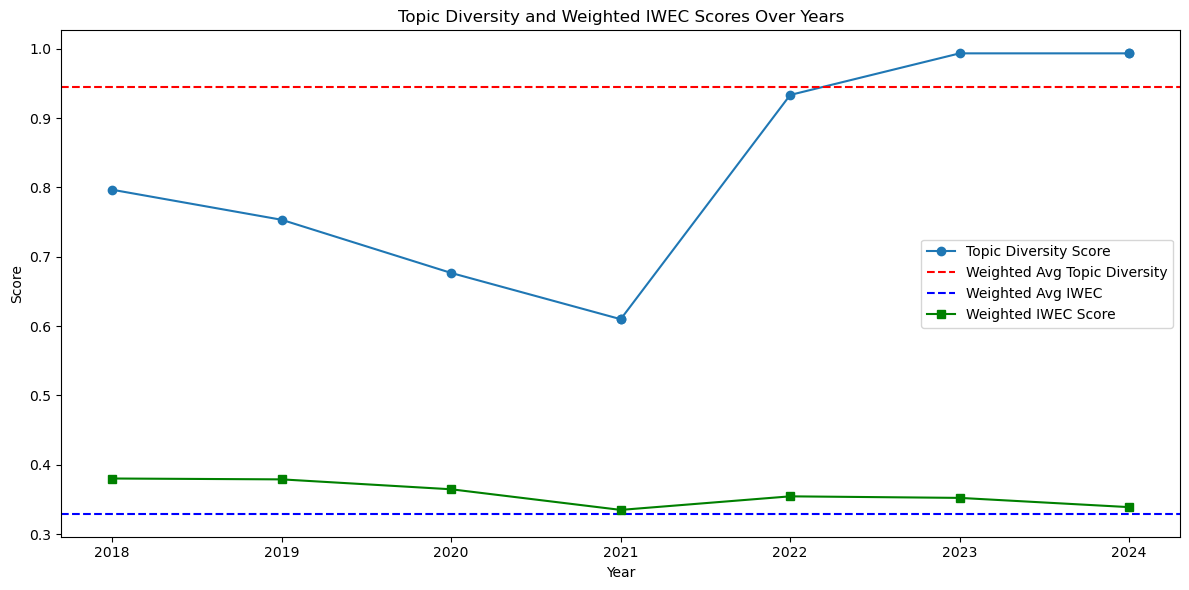

In [11]:
plt.figure(figsize=(12, 6))

# Plot Topic Diversity Scores
plt.plot(sorted_years_list, sorted_topic_diversity_scores, marker='o', label='Topic Diversity Score')
plt.axhline(y=avg_weighted_diversity, color='r', linestyle='--', label='Weighted Avg Topic Diversity')
plt.axhline(y=avg_weighted_iwec, color='b', linestyle='--', label='Weighted Avg IWEC')

# Plot IWEC Scores on the same graph
plt.plot(sorted_years_iwec, sorted_iwec_scores, marker='s', color='green', label='Weighted IWEC Score')

plt.title('Topic Diversity and Weighted IWEC Scores Over Years')
plt.xlabel('Year')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()